# Corner Detection, Template Matching, and Enhancing Contrast

<div style="text-align: center;">
  <a href="https://colab.research.google.com/github/MinooSdpr/opencv-python-tutorial/blob/main/Opencv-06.ipynb">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab" />
  </a>
  &nbsp;
  <a href="https://github.com/MinooSdpr/opencv-python-tutorial/blob/main/Opencv-06.ipynb">
    <img src="https://img.shields.io/badge/Open%20in-GitHub-24292e?logo=github&logoColor=white" alt="Open In GitHub" />
  </a>
</div>


## Corner Detection

The function `cv.cornerHarris()` in OpenCV is used to detect corners in an image using the Harris Corner Detection algorithm.

### What does `cv.cornerHarris` do?

1. **Computes image gradients** using the Sobel operator to find intensity changes.
2. **Calculates the structure tensor matrix** (second moment matrix) in a local neighborhood for each pixel.
3. **Computes the Harris response** for each pixel, which indicates how "corner-like" the pixel is.
4. Returns an image (`corners`) where each pixel value represents the corner strength (a floating-point value).

---

## Parameters Breakdown

| Parameter   | Value           | Description                                                                                        | Notes                                              |
| ----------- | --------------- | -------------------------------------------------------------------------------------------------- | -------------------------------------------------- |
| `image_gr`  | Grayscale image | The input grayscale image where corners need to be detected.                                       | Must be 8-bit or 32-bit floating point.            |
| `blockSize` | 3               | Size of the neighborhood (window) considered for corner detection at each pixel.                   | A small window (like 3x3) is common.               |
| `ksize`     | 10              | Aperture parameter for the Sobel operator (kernel size for computing image derivatives).           | Must be odd and between 1 and 31. (10 is invalid!) |
| `k`         | 0.04            | Harris detector free parameter — sensitivity factor to separate corners from edges and flat areas. | Typical values range from 0.04 to 0.06.            |

---

## Important Notes on Parameters:

* **blockSize** determines the size of the neighborhood around each pixel used to calculate the covariance matrix of derivatives. A larger blockSize means considering more pixels around each point.
* **ksize** must be an **odd integer between 1 and 31**. It specifies the size of the Sobel kernel used to calculate image derivatives (gradients). Common values are 3, 5, or 7.
* **k** controls sensitivity; lower values make the detector less sensitive to edges, while higher values may increase false detections.

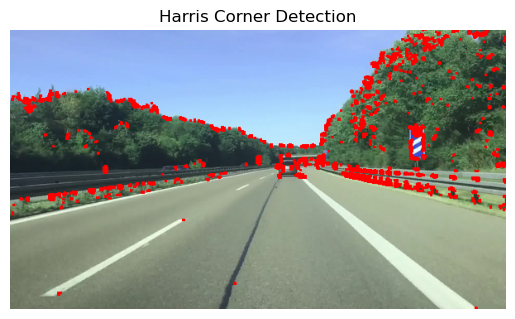

True

In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

image = cv.imread('lane_detection.jpg')
image_gr = cv.imread('lane_detection.jpg', 0)

corners = cv.cornerHarris(image_gr, 3, 3, 0.04)
corners_dilated = cv.dilate(corners, None)

image[corners_dilated > 0.01 * corners_dilated.max()] = [0, 0, 255]

image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)

plt.imshow(image_rgb)
plt.title('Harris Corner Detection')
plt.axis('off')
plt.show()

cv.imwrite('1_corners.png', image)


## Explanation of Template Matching

The OpenCV function `cv.matchTemplate()` is used to perform **template matching**, a technique in computer vision where a smaller image (template) is searched inside a larger image (source) to find areas that match the template.


### Parameters Breakdown

| Parameter  | Description                                                                                                        | Notes                                                        |
| ---------- | ------------------------------------------------------------------------------------------------------------------ | ------------------------------------------------------------ |
| `image`    | The source image where the template will be searched. Must be a single-channel (grayscale) or multi-channel image. | The image must be larger or equal in size to the template.   |
| `template` | The smaller image or pattern to search for inside the source image.                                                | Should be smaller than or equal in size to the source image. |
| `method`   | The comparison method used to evaluate similarity between the template and patches in the image.                   | See below for supported methods and their behaviors.         |

---

#### Matching Methods for `method` Parameter

| Method                    | Description                                                           | Interpretation of Result Values |
| ------------------------- | --------------------------------------------------------------------- | ------------------------------- |
| `cv.TM_SQDIFF`            | Sum of squared differences between template and image patch.          | Lower values = better match     |
| `cv.TM_SQDIFF_NORMED`     | Normalized sum of squared differences.                                | Lower values = better match     |
| `cv.TM_CCORR`             | Cross-correlation between template and image patch.                   | Higher values = better match    |
| `cv.TM_CCORR_NORMED`      | Normalized cross-correlation.                                         | Higher values = better match    |
| **`cv.TM_CCOEFF`**        | Correlation coefficient between template and image patch (zero mean). | Higher values = better match    |
| **`cv.TM_CCOEFF_NORMED`** | Normalized correlation coefficient (zero mean).                       | Higher values = better match    |

---

#### How `cv.TM_CCOEFF_NORMED` Works

* This method computes the **normalized cross-correlation coefficient** between the template and image patch after subtracting their respective means.
* The result values range from **-1** to **1**:

  * `1` means a perfect match (the patch is identical to the template).
  * Values close to 0 mean no correlation.
  * Negative values indicate inverse correlation.
* It is generally robust to lighting changes and contrast differences.


(-0.5, 1799.5, 1776.5, -0.5)

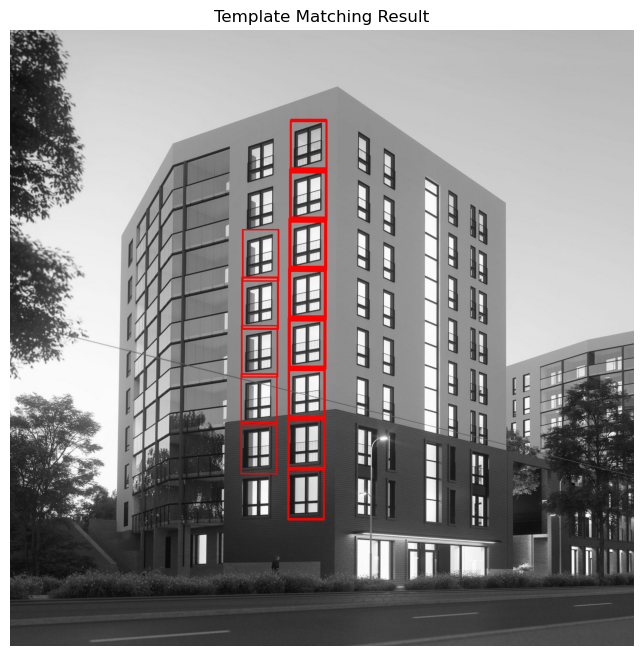

In [2]:
image = cv.imread("building1.jpg", 0)
template = cv.imread("building1_temp.jpg", 0)


h, w = template.shape
result = cv.matchTemplate(image, template, cv.TM_CCOEFF_NORMED)

threshold = 0.7

locations = np.where(result >= threshold)

image_color = cv.cvtColor(image, cv.COLOR_GRAY2BGR)

for pt in zip(*locations[::-1]):  # Reverse to get (x, y)
    cv.rectangle(image_color, pt, (pt[0] + w, pt[1] + h), (0, 0, 255), 2)

image_rgb = cv.cvtColor(image_color, cv.COLOR_BGR2RGB)

plt.figure(figsize=(10, 8))
plt.imshow(image_rgb)
plt.title('Template Matching Result')
plt.axis('off')

## 📝 Enhancing Contrast in Images with OpenCV

This script demonstrates how to enhance the contrast of a grayscale image (like an X-ray) using:

1. **Global Histogram Equalization**
2. **CLAHE (Contrast Limited Adaptive Histogram Equalization)**

Both techniques aim to improve visibility in low-contrast regions but differ in how they handle contrast enhancement.

---

## 📌 Techniques Explained

### 1. **Global Histogram Equalization**

The `cv.calcHist()` function in OpenCV is used to calculate the **histogram of an image**. A histogram is a graphical representation of the pixel intensity distribution in an image.

* Redistributes pixel intensities to span the full intensity range (0–255).
* Good for overall contrast enhancement.
* May **over-enhance noise** or **reduce local contrast**.


#### 📊 Parameter Table

| Parameter  | Type                  | Description                                                                           |
| ---------- | --------------------- | ------------------------------------------------------------------------------------- |
| `images`   | list of arrays        | List containing the image(s). Typically passed as `[image]`.                          |
| `channels` | list of ints          | Index of the channels to calculate histogram for. `[0]` for grayscale or blue in BGR. |
| `mask`     | `None` or image array | Optional mask. If provided, only masked pixels are included in the histogram.         |
| `histSize` | list of ints          | Number of bins for the histogram. E.g., `[256]` for 256 bins (for 8-bit images).      |
| `ranges`   | list of floats        | Intensity value range. For grayscale: `[0, 256]`.                                     |


### 2. **CLAHE**


The `cv.createCLAHE()` function in OpenCV is used to create a **CLAHE (Contrast Limited Adaptive Histogram Equalization)** object. This object can then be used to enhance contrast in grayscale images, especially useful in medical or low-light images.

* CLAHE divides the image into tiles and applies histogram equalization to each tile individually.
* Prevents over-amplification of noise by clipping histograms at a predefined limit (`clipLimit`).
* `tileGridSize` defines the size of each tile (e.g., 8x8).

#### ⚠️ Why CLAHE?

* **Global histogram equalization** can lead to over-enhancement and noise amplification.
* **CLAHE** limits this by:

  * Dividing the image into small tiles (e.g., 8x8 regions).
  * Clipping the histogram in each tile to limit contrast.
  * Redistributing the clipped histogram.
  * Using bilinear interpolation to smooth boundaries between tiles.


#### 📊 Parameter Table

| Parameter      | Type              | Default  | Description                                                                 |
| -------------- | ----------------- | -------- | --------------------------------------------------------------------------- |
| `clipLimit`    | `float`           | `40.0`   | Threshold for contrast clipping. Higher value = more contrast enhancement.  |
| `tileGridSize` | `tuple(int, int)` | `(8, 8)` | Size (in pixels) of grid tiles. Image is divided into this number of tiles. |

### ✅ Use Cases

* Medical imaging (X-rays, MRIs)
* Satellite images
* Low-light surveillance footage


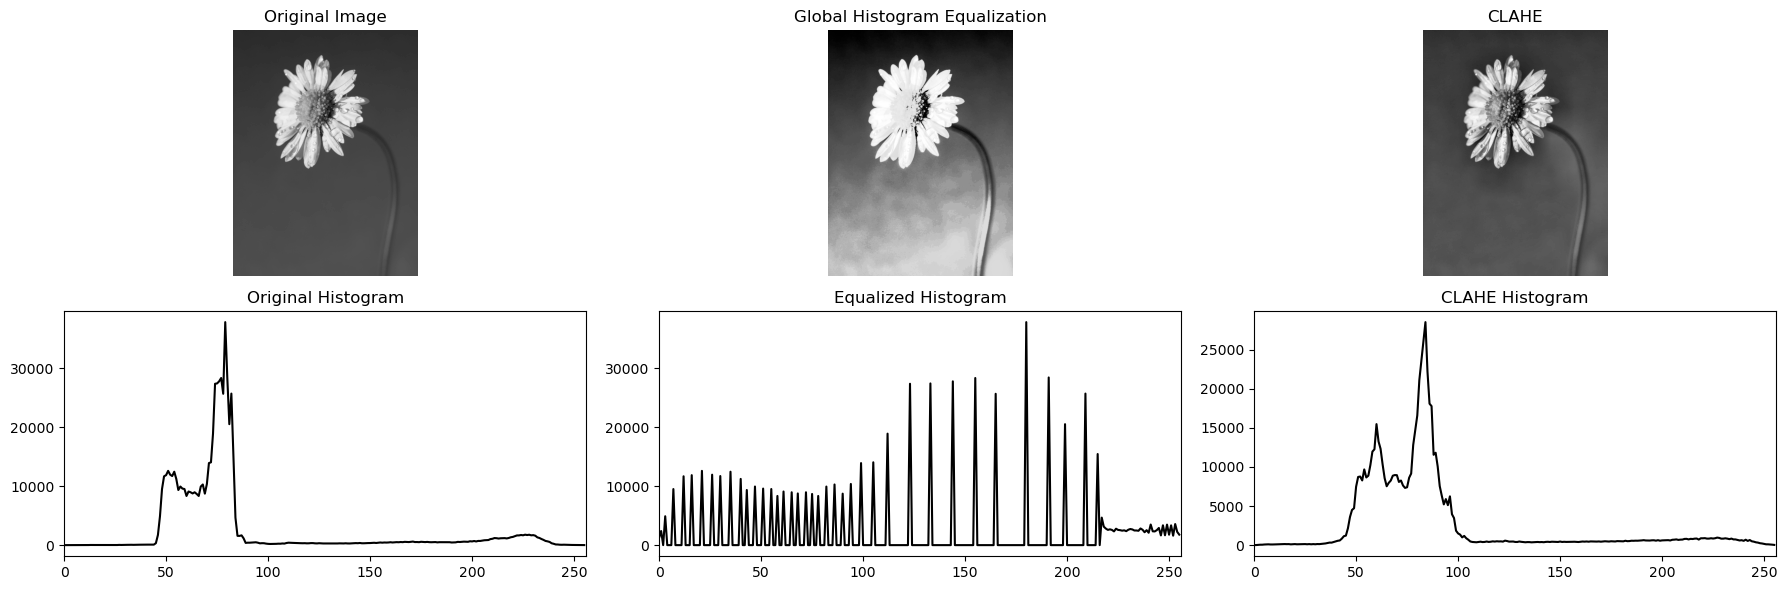

In [3]:
image = cv.imread("flower-sample.jpg", 0)

equalized_histogram = cv.equalizeHist(image)

clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
cl1 = clahe.apply(image)

img_hist = cv.calcHist([image], [0], None, [256], [0, 256])

img_equal_hist = cv.calcHist([equalized_histogram], [0], None, [256], [0, 256])

cl_equal_hist = cv.calcHist([cl1], [0], None, [256], [0, 256])

images = [image, equalized_histogram, cl1]
titles = ['Original Image', 'Global Histogram Equalization', 'CLAHE']

plt.figure(figsize=(18, 6))
for i in range(3):
    plt.subplot(2, 3, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')

hists = [img_hist, img_equal_hist, cl_equal_hist]
hist_titles = ['Original Histogram', 'Equalized Histogram', 'CLAHE Histogram']

for i in range(3):
    plt.subplot(2, 3, i + 4)
    plt.plot(hists[i], color='black')
    plt.title(hist_titles[i])
    plt.xlim([0, 256])

plt.tight_layout()
plt.show()


<div style="float:right;">
  <a href="https://github.com/MinooSdpr/Machine-Learning-101/blob/main/Session%2018/01%20-%20CNN%20.pptx"
     style="
       display:inline-block;
       padding:8px 20px;
       background-color:#414f6f;
       color:white;
       border-radius:12px;
       text-decoration:none;
       font-family:sans-serif;
       transition:background-color 0.3s ease;
     ">
    ▶️ Next
  </a>
</div>